In [ ]:
!pip install -q --upgrade --force-reinstall numpy pandas==2.2.2 matplotlib nibabel
!pip uninstall -y torch torchvision torchaudio -qq
!pip install -q torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121
!pip install -q nnunetv2==2.4.2 monai nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2

In [ ]:
# nnUNet v2

!pip install -q nnunetv2==2.4.2 monai==1.3.0 nibabel==5.2.1 simpleitk==2.3.1

import os, shutil, subprocess, textwrap, sys
from pathlib import Path
from google.colab import drive

drive.mount("/content/drive", force_remount=False)

# 1. 路径参数
DRIVE_ROOT      = Path("/content/drive/MyDrive/data")
DATASET         = "Dataset232_BraTS_2023_rGANs"
FOLDS_LIST      = ["0", "1", "2", "3", "4"]          # 多折集成
TRAINER_DIRNAME = "nnUNetTrainer__nnUNetPlans__3d_fullres"
CHECKPOINT_NAME = "checkpoint_final.pth"

# 2. 环境变量
os.environ.update({
    "nnUNet_raw":          "/content/nnUNet_raw",
    "nnUNet_preprocessed": "/content/nnUNet_preprocessed",
    "nnUNet_results":      "/content/nnUNet_results",
    "RESULTS_FOLDER":      "/content/nnUNet_results",
})

# 3. 构建 imagesTs
RAW_TS = Path(os.environ["nnUNet_raw"]) / DATASET / "imagesTs"
RAW_TS.mkdir(parents=True, exist_ok=True)

MOD_MAP = {"t1c": "0000", "t1n": "0001", "t2f": "0002", "t2w": "0003"}
for case_dir in (DRIVE_ROOT / "training_data").iterdir():
    if not case_dir.is_dir():
        continue
    case = case_dir.name
    for mod, idx in MOD_MAP.items():
        src = case_dir / f"{case}-{mod}.nii.gz"
        dst = RAW_TS   / f"{case}_{idx}.nii.gz"
        dst.unlink(missing_ok=True)
        dst.symlink_to(src.resolve())
print("linked raw images →", RAW_TS)

# 4. 复制 nnUNet_preprocessed
PREPROC_DST = Path(os.environ["nnUNet_preprocessed"]) / DATASET
PREPROC_DST.mkdir(parents=True, exist_ok=True)
for fn in ["dataset.json", "plans.json"]:
    shutil.copy(DRIVE_ROOT / fn, PREPROC_DST / fn)
for fold in DRIVE_ROOT.glob("fold_*"):
    if fold.is_dir():
        shutil.copytree(fold, PREPROC_DST / fold.name, dirs_exist_ok=True)
print("copied preprocessed →", PREPROC_DST)

# 5. 准备 nnUNet_results
RES_DST = Path(os.environ["nnUNet_results"]) / DATASET
TR_DIR  = RES_DST / TRAINER_DIRNAME
for f in FOLDS_LIST:
    fold_dir = TR_DIR / f"fold_{f}"
    fold_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy(DRIVE_ROOT / CHECKPOINT_NAME, fold_dir / CHECKPOINT_NAME)
for fn in ["dataset.json", "plans.json"]:
    shutil.copy(DRIVE_ROOT / fn, TR_DIR / fn)
print("copied weights & plans →", TR_DIR)

# 6. 运行推理并实时显示进度
device = "cuda" if Path("/usr/bin/nvidia-smi").exists() else "cpu"
folds  = " ".join(FOLDS_LIST)

cmd = textwrap.dedent(f"""
    nnUNetv2_predict \
      -i {RAW_TS} \
      -o /content/pred \
      -d {DATASET} \
      -c 3d_fullres \
      -f {folds} \
      -device {device}
""").strip()

print("\nRunning command:\n", cmd, "\n")

process = subprocess.Popen(
    cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)

# 实时逐行输出
for line in iter(process.stdout.readline, ""):
    sys.stdout.write(line)
    sys.stdout.flush()

process.wait()
if process.returncode != 0:
    raise RuntimeError("nnUNetv2_predict failed")

print("\ninference done → /content/pred")

# 7. 复制结果到 Drive
OUT_DIR = DRIVE_ROOT / "output"
OUT_DIR.mkdir(exist_ok=True)
for p in Path("/content/pred").glob("*.nii*"):
    shutil.copy(p, OUT_DIR / p.name)
print("results saved to", OUT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
linked raw images → /content/nnUNet_raw/Dataset232_BraTS_2023_rGANs/imagesTs
copied preprocessed → /content/nnUNet_preprocessed/Dataset232_BraTS_2023_rGANs
copied weights & plans → /content/nnUNet_results/Dataset232_BraTS_2023_rGANs/nnUNetTrainer__nnUNetPlans__3d_fullres

Running command:
 nnUNetv2_predict       -i /content/nnUNet_raw/Dataset232_BraTS_2023_rGANs/imagesTs       -o /content/pred       -d Dataset232_BraTS_2023_rGANs       -c 3d_fullres       -f 0 1 2 3 4       -device cuda 

/usr/local/lib/python3.11/dist-packages/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

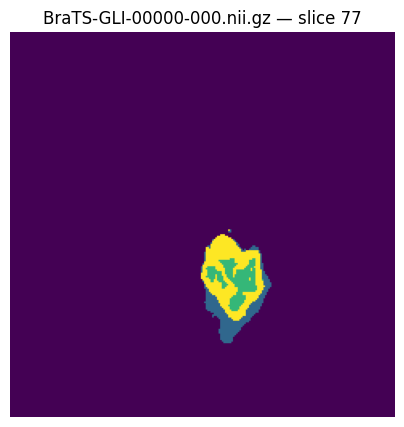

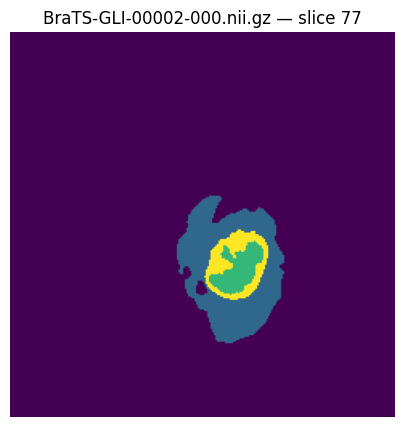

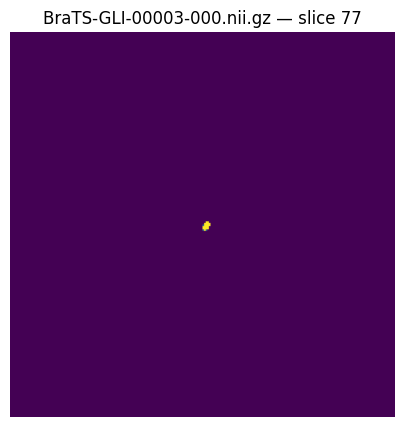

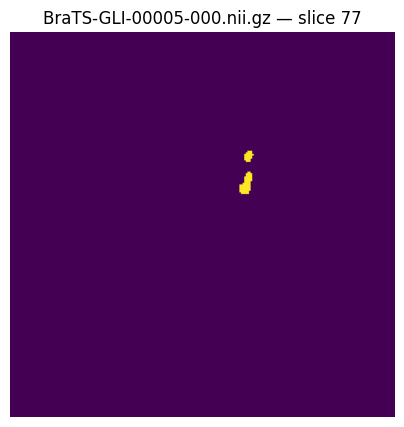

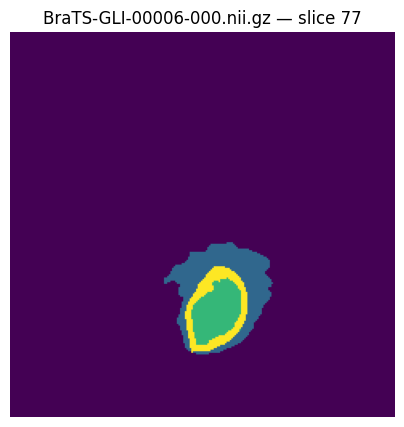

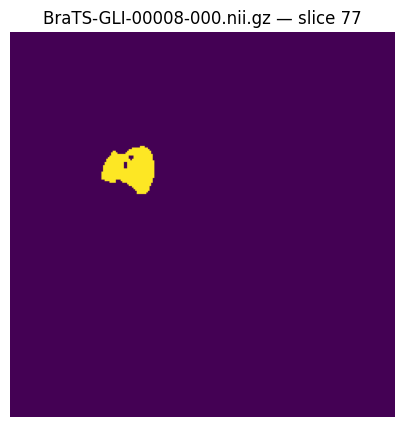

In [ ]:
import os
import nibabel as nib   # or: import SimpleITK as sitk
import matplotlib.pyplot as plt

# 改成你自己的文件夹路径
seg_dir = "/content/drive/MyDrive/data/output"

files = sorted(f for f in os.listdir(seg_dir) if f.endswith('.nii.gz'))

# 仅展示前 6 个文件的中间切片
for f in files[:6]:
    path = os.path.join(seg_dir, f)
    img = nib.load(path)                # SimpleITK: img = sitk.ReadImage(path); arr = sitk.GetArrayFromImage(img)
    arr = img.get_fdata()               # SimpleITK: arr obtained above, shape (z, y, x)
    slice_idx = arr.shape[2] // 2       # SimpleITK: arr.shape[0] // 2
    slice_data = arr[:, :, slice_idx]   # SimpleITK: arr[slice_idx, :, :]

    plt.figure(figsize=(5,5))
    plt.title(f"{f} — slice {slice_idx}")
    plt.imshow(slice_data.T, origin='lower')
    plt.axis('off')
    plt.show()

📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00000-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00002-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00003-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00005-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00006-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00008-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00008-001_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00009-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00009-001_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00011-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00012-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00014-000_compare.png
📷 保存对比图 → /content/drive/MyDrive/data/output/BraTS-GLI-00014-001_compare.png

## Segmentation Metrics

,case,dice,iou
34,BraTS-GLI-00032-001,0.993472,0.987029
24,BraTS-GLI-00022-001,0.989482,0.979183
2,BraTS-GLI-00003-000,0.986061,0.972506
4,BraTS-GLI-00006-000,0.985121,0.970679
12,BraTS-GLI-00014-001,0.984356,0.969194
10,BraTS-GLI-00012-000,0.981884,0.964413
26,BraTS-GLI-00024-001,0.981833,0.964313
20,BraTS-GLI-00020-001,0.981449,0.963573
25,BraTS-GLI-00024-000,0.978824,0.958525
16,BraTS-GLI-00017-001,0.978567,0.958033


### Overlay Comparisons（前 6 张）

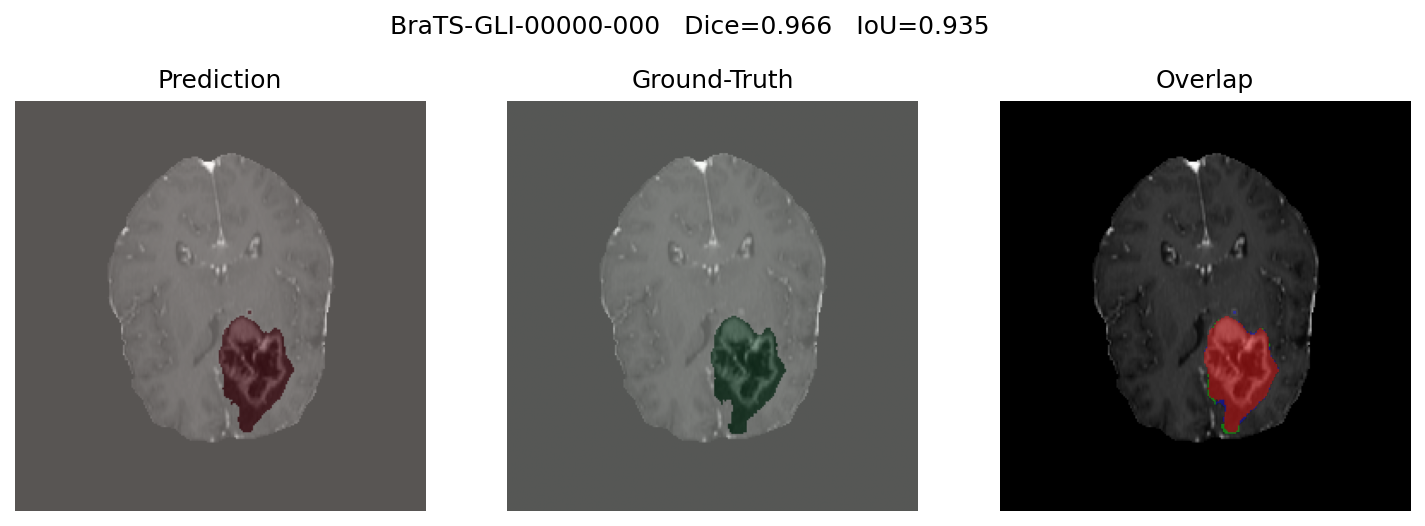

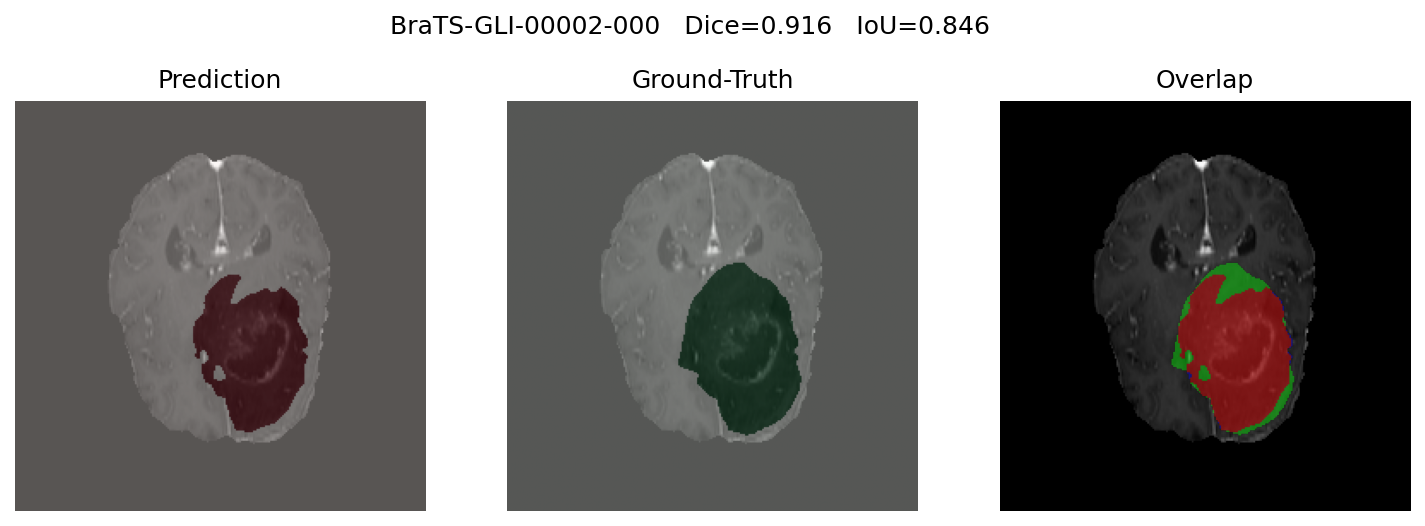

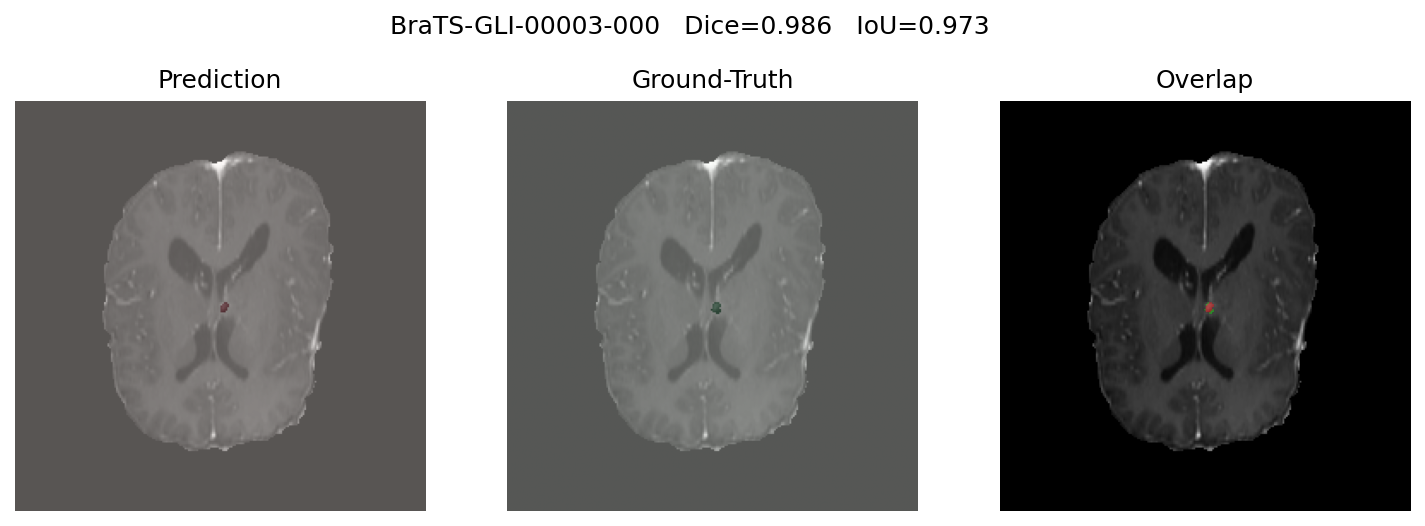

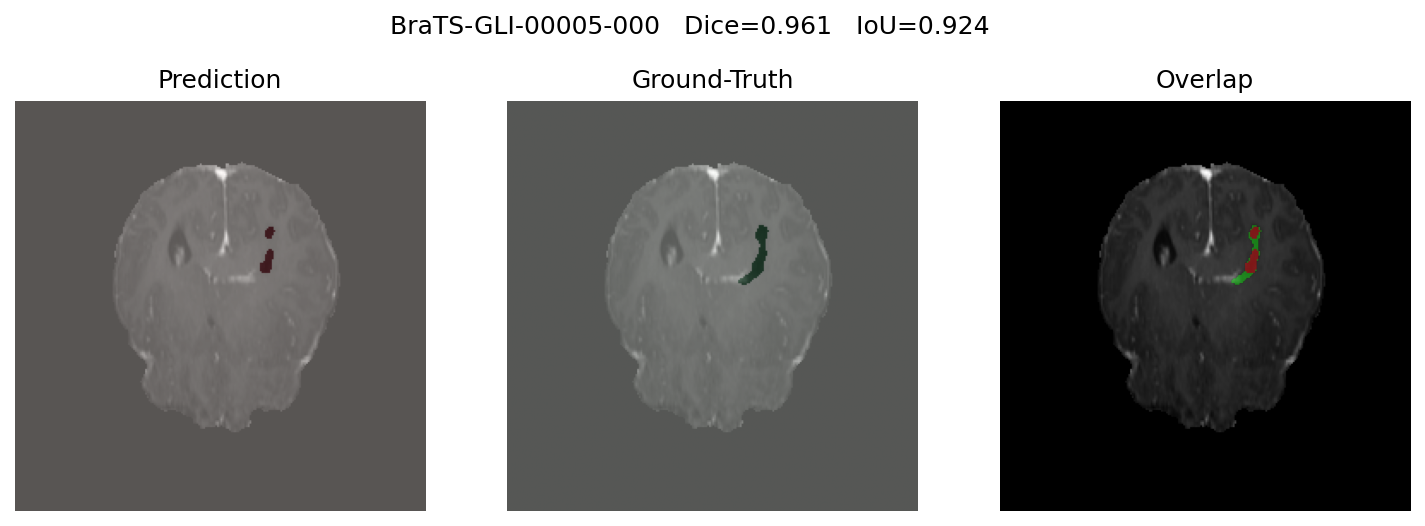

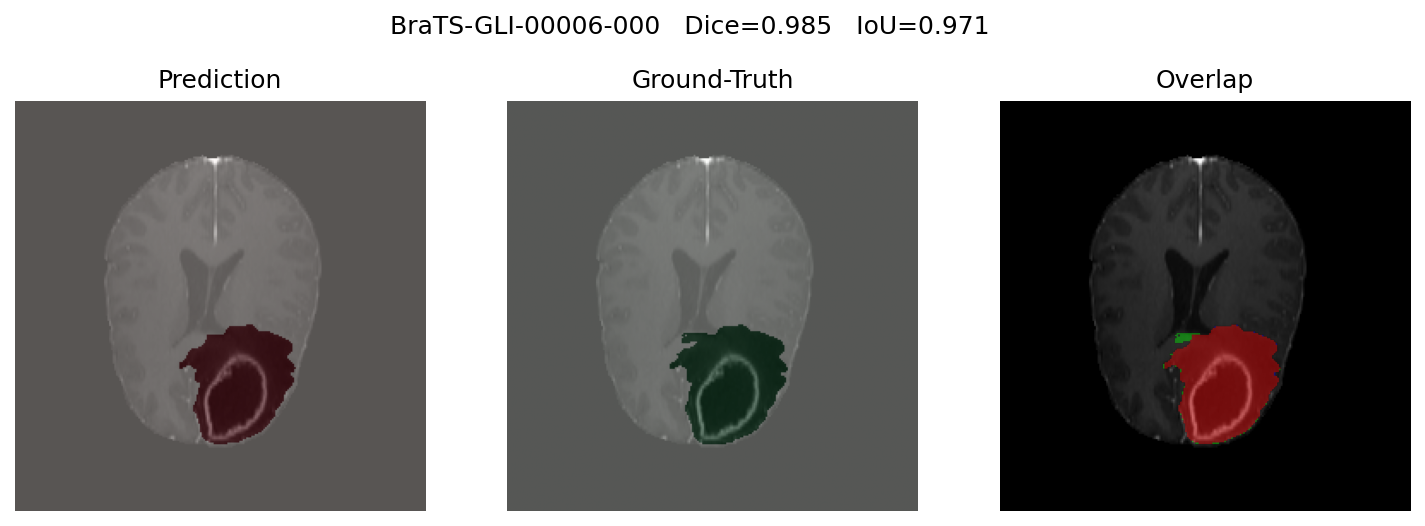

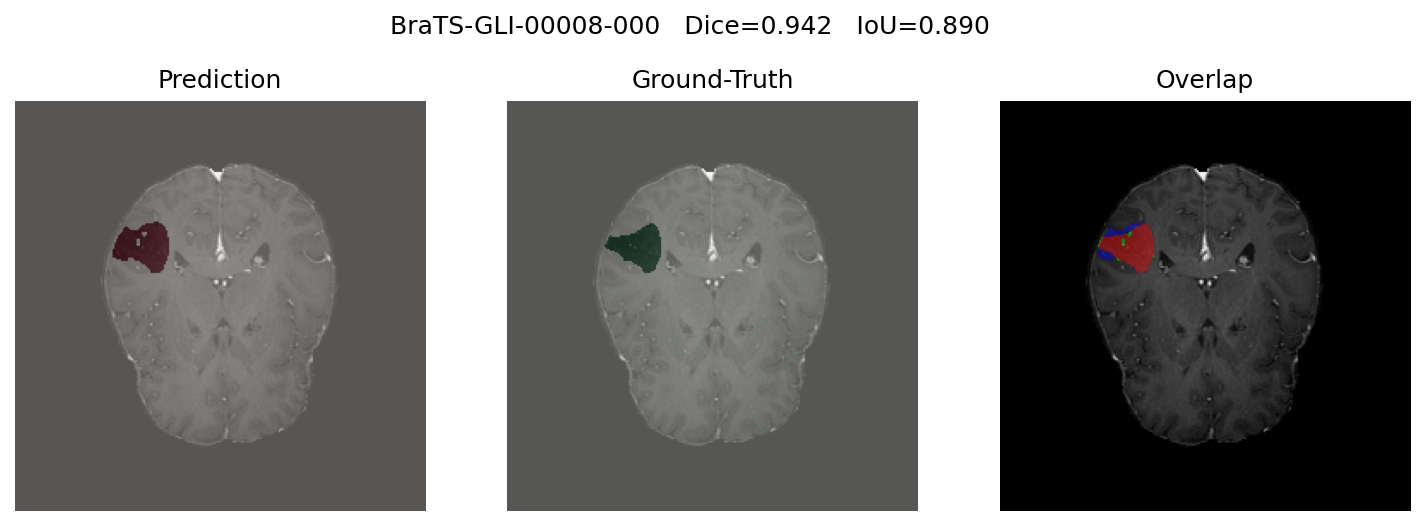

In [ ]:


import os, json, numpy as np, pandas as pd, nibabel as nib, matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Image, display, Markdown


OUTPUT_DIR = Path("/content/drive/MyDrive/data/output")        # ← 推理结果 *.nii.gz
TRAIN_DIR  = Path("/content/drive/MyDrive/data/training_data") # ← 原始数据
MODALITY   = "t1c"                                             # 背景模态


pred_fps = sorted(OUTPUT_DIR.glob("*.nii.gz"))
cases = [fp.name.replace(".nii.gz", "").replace("_seg", "") for fp in pred_fps]


metrics   = []
png_paths = []

for case in cases:
    # ------------ 文件路径 ------------
    pred_fp = OUTPUT_DIR / f"{case}_seg.nii.gz"
    if not pred_fp.exists():      # 若 nnU-Net 不带 _seg 后缀
        pred_fp = OUTPUT_DIR / f"{case}.nii.gz"
    gt_fp  = TRAIN_DIR / case / f"{case}-seg.nii.gz"
    img_fp = TRAIN_DIR / case / f"{case}-{MODALITY}.nii.gz"
    if not img_fp.exists():
        img_fp = TRAIN_DIR / case / f"{case}-t1n.nii.gz"       # 备用模态

    # ------------ 检查完整性 ------------
    if not (pred_fp.exists() and gt_fp.exists() and img_fp.exists()):
        print(f"⚠️  跳过 {case}（缺文件）")
        continue

    # ------------ 读取数据 ------------
    pred = nib.load(pred_fp).get_fdata() > 0
    gt   = nib.load(gt_fp).get_fdata()  > 0
    img  = nib.load(img_fp).get_fdata()

    # ------------ 指标 ------------
    tp = np.logical_and(pred, gt).sum()
    fp = np.logical_and(pred, ~gt).sum()
    fn = np.logical_and(~pred, gt).sum()
    dice = 2*tp / (2*tp + fp + fn + 1e-8)
    iou  = tp   / (tp   + fp + fn + 1e-8)
    metrics.append(dict(case=case, dice= dice, iou=iou))

    z = img.shape[2] // 2
    img_sl  = img[:, :, z]
    pred_sl = pred[:, :, z]
    gt_sl   = gt[:, :, z]
    img_n   = (img_sl - img_sl.min()) / (img_sl.ptp() + 1e-8)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img_n.T, cmap="gray", origin="lower")
    ax[0].imshow(pred_sl.T, cmap="Reds", alpha=.35, origin="lower")
    ax[0].set_title("Prediction"); ax[0].axis("off")

    ax[1].imshow(img_n.T, cmap="gray", origin="lower")
    ax[1].imshow(gt_sl.T, cmap="Greens", alpha=.35, origin="lower")
    ax[1].set_title("Ground-Truth"); ax[1].axis("off")
    overlay = np.zeros((*pred_sl.T.shape, 4))
    overlay[np.logical_and(pred_sl.T, gt_sl.T)] = [1, 0, 0, .40]   # TP
    overlay[np.logical_and(~pred_sl.T, gt_sl.T)] = [0, 1, 0, .40]  # FN
    overlay[np.logical_and(pred_sl.T, ~gt_sl.T)] = [0, 0, 1, .40]  # FP
    ax[2].imshow(img_n.T, cmap="gray", origin="lower")
    ax[2].imshow(overlay, origin="lower")
    ax[2].set_title("Overlap"); ax[2].axis("off")

    fig.suptitle(f"{case}   Dice={dice:.3f}   IoU={iou:.3f}")
    png_fp = OUTPUT_DIR / f"{case}_compare.png"
    fig.savefig(png_fp, dpi=150, bbox_inches="tight")
    plt.close(fig)

    png_paths.append(png_fp)
    print(" 保存对比图 →", png_fp)


df = pd.DataFrame(metrics).sort_values("dice", ascending=False)
df.to_csv(OUTPUT_DIR / "metrics_summary.csv", index=False)
print("\n指标保存 →", OUTPUT_DIR / "metrics_summary.csv")

display(Markdown("## Segmentation Metrics"))
display(df)

display(Markdown("### Overlay Comparisons"))
for p in png_paths[:6]:
    display(Image(str(p)))